# Descriptive graphs

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [80]:
# plt.style.use('seaborn-v0_8-dark')
# plt.rcParams["font.family"] = 'times new roman'

# plot formatting
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# minor axis
plt.rcParams['xtick.minor.bottom'] = True

# grid lines
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'both'
plt.rcParams['grid.alpha'] = 0.25
plt.rcParams['grid.linewidth'] = 2

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# orders of magnitude
M = 1_000_000
B = 1_000_000_000
T = 1_000_000_000_000

In [3]:
# paths
data_dir = os.path.abspath('data')
fig_dir = os.path.abspath('figures')

# Canada's trade partners

In [81]:
# trade by trading partners
src = os.path.join(data_dir, 'CA-part.csv')
tp = pd.read_csv(src, index_col=[0, 1, 2])

In [ ]:
# EAA https://www.gov.uk/eu-eea.

# European Union
EU = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy',
    'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
    'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
    ]

# European Economic Area (though Canada has no trade with Liechtenstein)
EEA = ['Iceland', 'Liechtenstein', 'Norway'] + EU

# EAA plus UK and Switzerland
EEA_plus = EEA + ['United Kingdom', 'Switzerland']

In [83]:
# trade series with countries across time
cous = tp.pivot_table(index=['year', 'cou'], values=tp.columns, aggfunc='sum')
cous = cous.reset_index()
cous = cous.sort_values(['year', 'tradebalance'])

cous['cou'] = cous['cou'].str.split(' (', regex=False).str[0]

# make imports negative
cous['imports'] = -cous['imports']

# label
cous['eu'] = cous['cou'].isin(EU)
cous['eea'] = cous['cou'].isin(EEA)
cous['eea+'] = cous['cou'].isin(EEA_plus)



eeap = cous.pivot_table(index=['year', 'eea+'], values=tp.columns, aggfunc='sum')
eeap = eeap.reset_index()
eeap = eeap[eeap['eea+']]
eeap = eeap.rename(columns={'eea+' : 'cou'})
eeap['cou'] = 'EEA+'

cous = pd.concat([cous, eeap])
cous = cous.drop(columns=['eu', 'eea', 'eea+'])

Saved: /home/qcx201/Projects/CAtrade/figures/03-net_import_partners.png


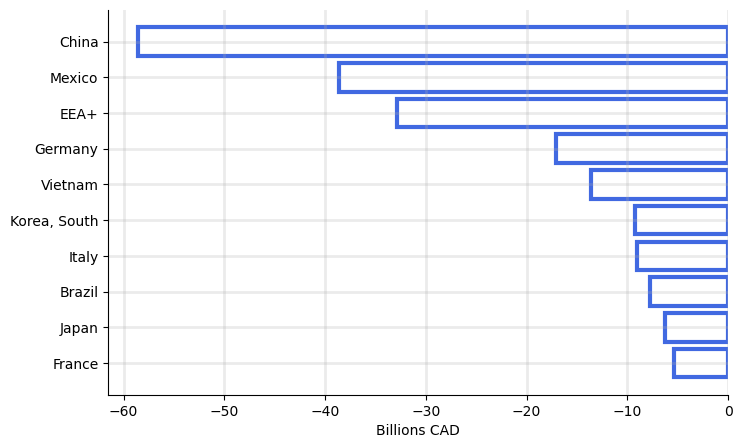

,tradebalance
cou,
China,-58.588303
Mexico,-38.616405
EEA+,-32.852237
Germany,-17.055283
Vietnam,-13.62523
"Korea, South",-9.204426
Italy,-9.093602
Brazil,-7.774938
Japan,-6.298306


In [ ]:
# number of top
top = 10
year = 2024

# trade in latest year
cond = cous['year'] == year
df = cous[cond]

data_dict = {}

# top net import partners
title, col = f'Canada\'s top {top} net import partners ({year})', 'tradebalance'
data = df.sort_values(col)
cond = data['cou'].str.contains('Total') | data['cou'].str.contains('Import')
data = data[~cond] # remove totals and reimports for net trade balance rank
data_dict[title] = {'data' : data, 'col' : col}

# top net export partners
title, col = f'Canada\'s top {top} net export partners ({year})', 'tradebalance'
data = df.sort_values(col, ascending=False)
cond = data['cou'].str.contains('Total') | data['cou'].str.contains('Import')
data = data[~cond] # remove totals and reimports for net trade balance rank
data_dict[title] = {'data' : data, 'col' : col}

# top gross import partners
title, col = f'Canada\'s top {top} (gross) import partners ({year})', 'imports'
data = df.sort_values(col)
data_dict[title] = {'data' : data, 'col' : col}

# top gross export partners
title, col = f'Canada\'s top {top} (gross) export partners ({year})', 'exports'
data = df.sort_values(col, ascending=False)
data_dict[title] = {'data' : data, 'col' : col}


for title, params in data_dict.items():
    
    data = params['data']
    col = params['col']
    
    # add 2 for all countries and EEA+
    nhead = top if 'net' in title else top + 2
    data = data.head(nhead)

    x, y = data['cou'], data[col] / B

    fig, ax = plt.subplots(figsize=(8, 5))

    # formatting
    kwargs = {
        'color' : 'tomato' if 'export' in title else 'royalblue',
        'fill' : False if 'net' in title else True,
        'linewidth' : 3
    }
    kwargs['edgecolor'] = kwargs['color'] if 'net' in title else None

    # plot bar
    bars = ax.barh(x, y, **kwargs)
    
    # add hatch to bar for total all countries export/import
    if 'net' not in title:
        for i in (0, 2):
            bars[i].set_hatch('///')
            bars[i].set_edgecolor('white')

    # ax.set_title(title) # remove title for article
    ax.set_xlabel('Billions CAD')

    # invert order of countries
    plt.gca().invert_yaxis()
    
    # save figures
    n = 3 if 'gross' in title else 4
    tag = '_'.join(title.split()[-n:-1])
    file = f'03-{tag}.png'

    dst = os.path.join(fig_dir, file)
    plt.savefig(dst, bbox_inches='tight')

    print('Saved:', dst)
    
    plt.show()
    display(pd.DataFrame([x, y]).T.set_index('cou'))

## Our main trade partners through time

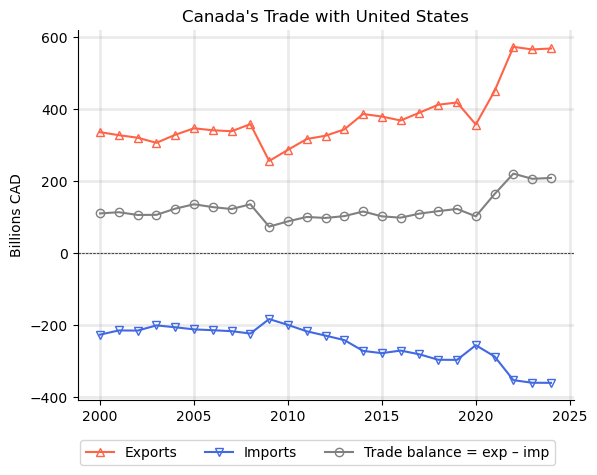

In [7]:
fig, ax = plt.subplots()

cond = cous['cou'] == 'United States'
us = cous[cond]

labels = {'exports' : 'Exports', 'imports' : 'Imports', 'tradebalance' : 'Trade balance = exp – imp'}

markers = ['^', 'v', 'o']
palette = ['tomato', 'royalblue', 'gray']
for col, marker, c in zip(labels, markers, palette):
    
    x, y = us['year'], us[col] / B
    
    ax.plot(x, y, marker=marker, c=c, fillstyle='none', label=labels[col])

ax.set_title('Canada\'s Trade with United States')
ax.set_ylabel('Billions CAD')
ax.axhline(0, c='black', ls='--', lw=0.5)

fig.legend(loc='center', bbox_to_anchor=(0.5, 0), ncol=3)

plt.show()

## What do we trade?

In [8]:
# Canada's trade by sector/product

## Top trade partners by sector

In [9]:
# Breakdown trade by sector with top trader